In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import pickle

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
data = pd.read_csv("Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data.shape

(568454, 10)

In [4]:
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,16
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [5]:
total_rows=data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows=data.shape[0]
removed_rows=total_rows-remaining_rows
print("No. of rows removed :",removed_rows)
print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 43

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


In [6]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]
print("No. of rows removed :", a-b)
print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 174750

Percentage of data removed: 30.74%
Percentage of data remaining: 69.25%


In [7]:
a=data.shape[0]
idx=data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)
b=data.shape[0]
print("No. of rows removed :", a-b)
print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:69.25%


In [8]:
def create_target(x):
    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"
data.loc[:,'target']=data.Score.apply(create_target)

In [ ]:
data[['Score','target']].sample(5)

,Score,target
9930,5,Positive
110800,5,Positive
367348,2,Negative
126152,3,Neutral
23759,5,Positive


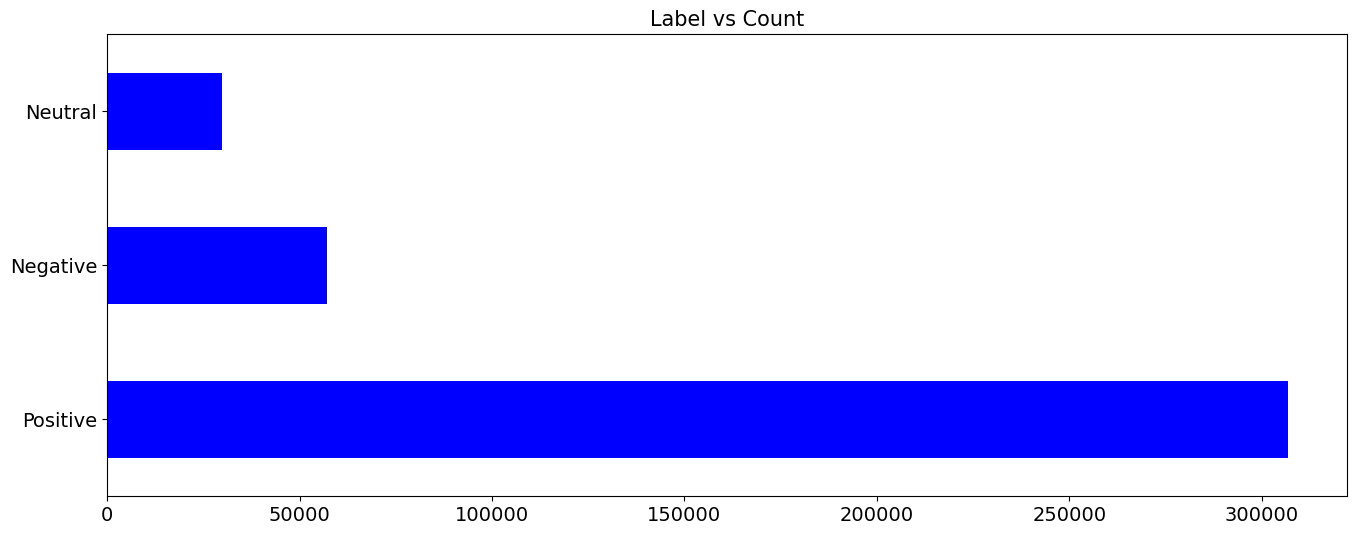

In [10]:
fig, ax = plt.subplots(figsize=(16,6))
vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [ ]:
neutral=data.loc[data.target=="Neutral"] 
positive=data.loc[data.target=="Positive"].sample(50000)
negative=data.loc[data.target=="Negative"].sample(50000)
data=pd.concat([positive, negative, neutral])
data.shape

(129770, 11)

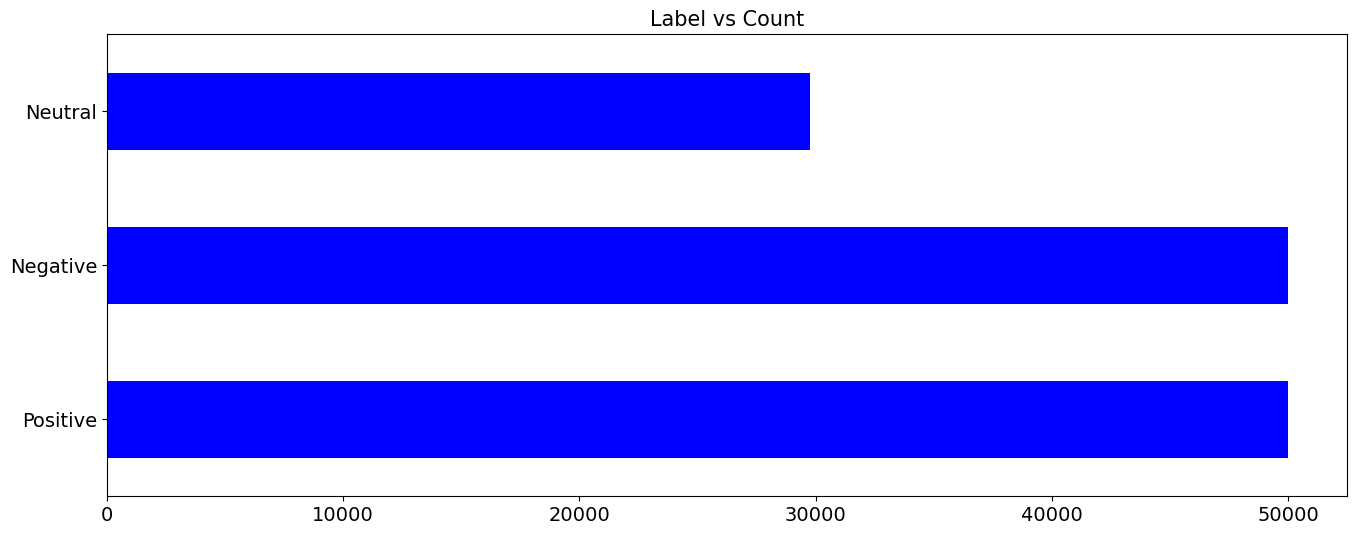

In [12]:
fig, ax=plt.subplots(figsize=(16, 6))
vc=data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count",fontsize=15)
plt.show()

In [13]:
total_stopwords=set(stopwords.words('english'))
negative_stop_words=set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)
final_stopwords=total_stopwords-negative_stop_words
final_stopwords.add("one")
print(final_stopwords)

{'he', 'a', "i've", 'herself', "we'd", 'aren', 'mustn', 'don', 'does', 'd', 'having', 'into', 'what', 'how', 'during', 'whom', 'haven', 'than', 'y', 'your', 'each', 'on', 'who', 'shan', 'hers', 'further', "i'll", 'that', 'myself', 'if', 'being', 'isn', 'hasn', 'me', 'o', "we're", 'yourself', 'weren', "he'll", 'again', "you've", 'from', 'have', 'after', 'just', 'while', "she's", 'to', 'with', 's', 'but', 've', 'we', 'the', 'doing', 'then', 'most', 'this', 'was', 'some', 'over', "you're", 'when', 'all', 'an', 'had', 'i', "they're", 'can', 'before', 'is', 'my', 'too', "it'll", 'ain', 'won', 'yours', 'until', 'has', 'such', 'been', 'she', 're', 'of', 'themselves', 'are', 'about', 'own', 'they', 'his', 'only', 'against', 'do', 'below', 'any', 'needn', "they've", 'because', 'couldn', 'once', 'why', 'himself', 'itself', 't', 'were', 'it', 'here', 'by', 'or', 'down', "she'd", 'there', 'shouldn', 'more', 'theirs', 'hadn', 'through', "she'll", 'wouldn', 'am', 'few', 'as', 'off', 'will', 'in', 'u

In [14]:
stemmer = PorterStemmer()
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")

In [15]:
def preprocessor(review):
    review = HTMLTAGS.sub(r'', review)
    review = review.translate(table)
    review = review.translate(remove_digits)
    review = review.lower()
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    review = [word for word in review.split()
              if word not in final_stopwords]
    review = ' '.join([stemmer.stem(word) for word in review])
    return review

In [16]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


'I drink 3-4 cups of hot tea daily & Xagave does not over power the favor of the various types I enjoy. The change in the label was alarming but once I used it, I knew it was the same.  It is not always carried in the store I shop so ordering on line was a blessing.'

In [17]:
data.Text=data.Text.apply(preprocessor) 
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'drink cup hot tea daili xagav not power favor variou type enjoy chang label alarm use knew not alway carri store shop order line bless'

In [18]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

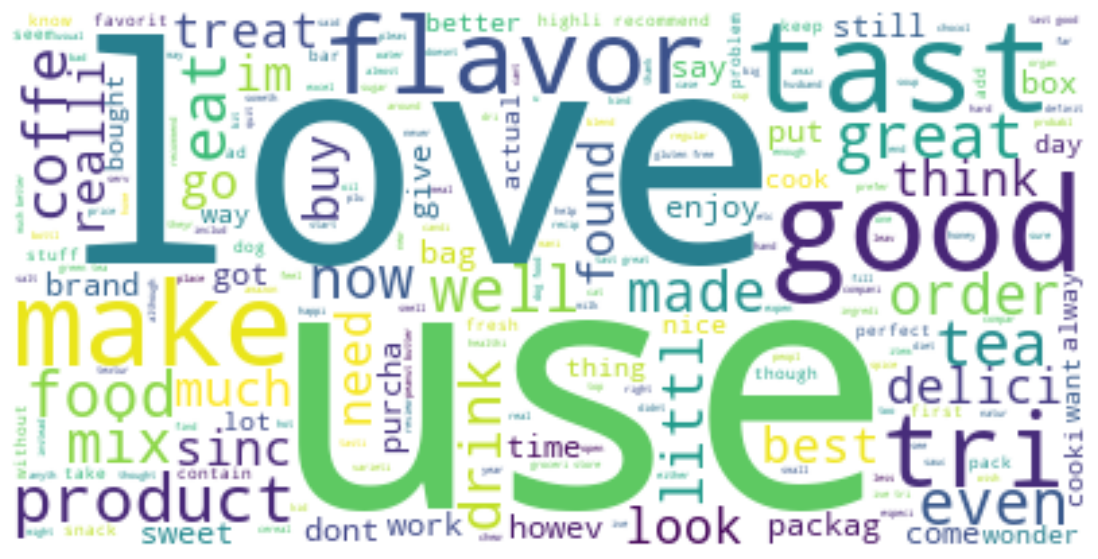

In [ ]:
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))
generate_wcloud(text)

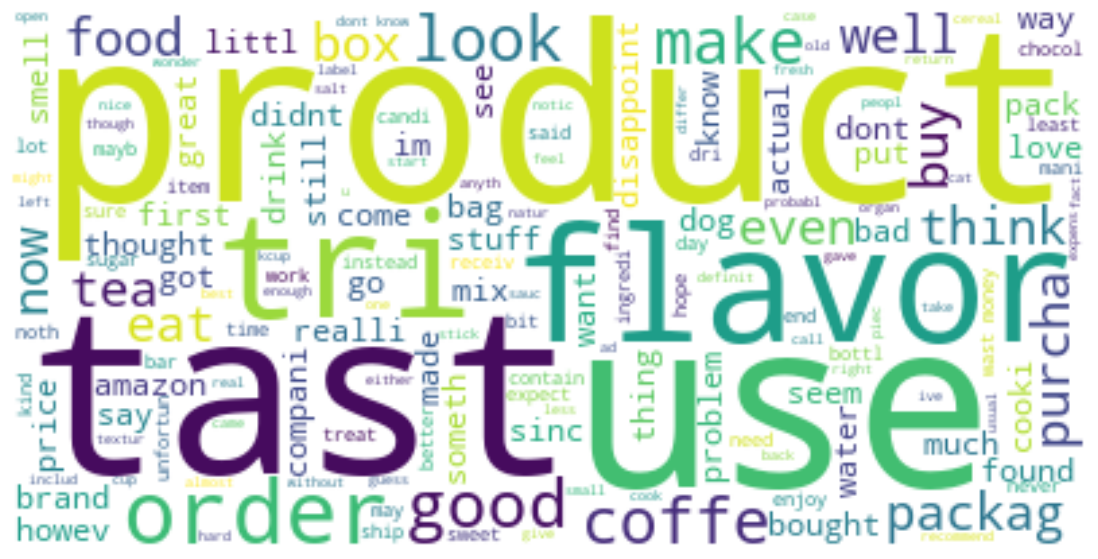

In [ ]:
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))
generate_wcloud(text)

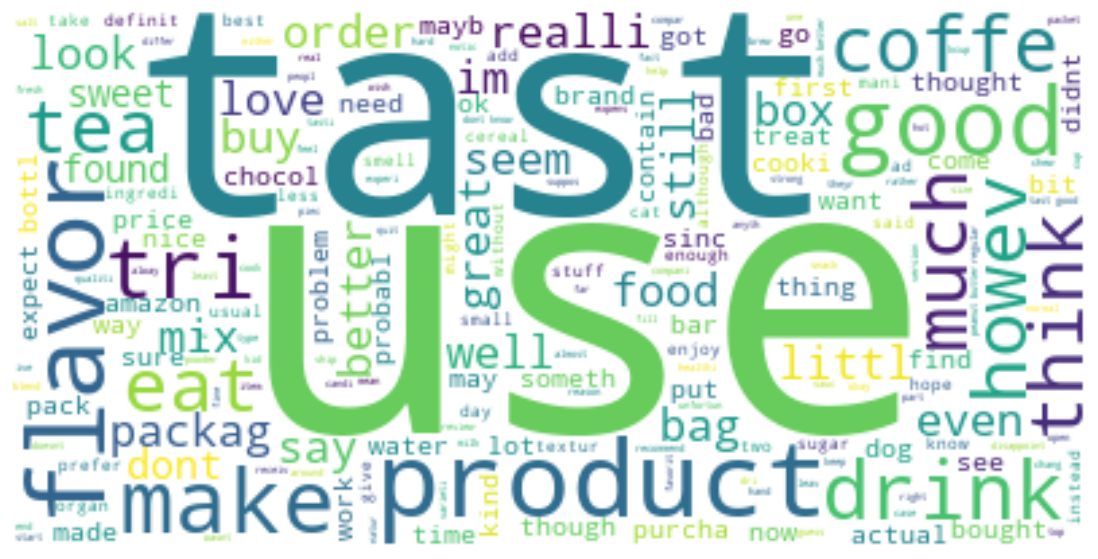

In [21]:
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))
generate_wcloud(text)

In [22]:
X = data.Text
y = data.target
X_train, X_test, y_train, y_test = train_test_split(    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [23]:
X_train.shape, X_test.shape

((103816,), (25954,))

In [24]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [26]:
labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)
labels = labelEncoder.classes_.tolist()
print(labels) 

['Negative', 'Neutral', 'Positive']


In [27]:
def train_and_eval(model, trainX, trainY, testX, testY):
    _ = model.fit(trainX, trainY)
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

In [28]:
C = [0.001, 0.01, 0.1, 1, 10]
for c in C: 
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.6999306465284735
Test accuracy score : 0.6928411805502042

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.738219542267088
Test accuracy score : 0.7160360638051938

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7657682823456885
Test accuracy score : 0.7160745935115974

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.7866706480696617
Test accuracy score : 0.70667334514911

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7928450335208446
Test accuracy score : 0.6946906064575787

 ----------------------------------------


C:\Users\SHIVA KUMAR\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
alphas = [0, 0.2, 0.6, 0.8, 1]
for a  in alphas: 
    nb_model = MultinomialNB(alpha=a)
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)

C:\Users\SHIVA KUMAR\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(



MultinomialNB(alpha=0)
Train accuracy score : 0.7100832241658318
Test accuracy score : 0.6840949371965785

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7093029976111582
Test accuracy score : 0.6854434769207058

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7086287277490946
Test accuracy score : 0.6860599522231641

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.70836865223087
Test accuracy score : 0.6860599522231641

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.708272327964861
Test accuracy score : 0.6859828928103567

 ----------------------------------------


In [30]:
C = [0.001, 0.01, 0.1, 1, 10]
for c in C: 
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.6446886799722586
Test accuracy score : 0.6432149187023195

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.6788837944054866
Test accuracy score : 0.6743469214764584

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7307544116513832
Test accuracy score : 0.7159975340987902

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.7630134083378285
Test accuracy score : 0.7213146335824921

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7842143792864298
Test accuracy score : 0.70921630577175

 ----------------------------------------


In [31]:
alphas = [0, 0.2, 0.6, 0.8, 1]
for a  in alphas: 
    nb_model = MultinomialNB(alpha=a)
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

C:\Users\SHIVA KUMAR\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(



MultinomialNB(alpha=0)
Train accuracy score : 0.715487015488942
Test accuracy score : 0.6871387840024659

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7136953841411728
Test accuracy score : 0.6890652693226478

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7111716883717346
Test accuracy score : 0.6889496802034368

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7100735917392309
Test accuracy score : 0.6889111504970332

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7086287277490946
Test accuracy score : 0.6883717346073823

 ----------------------------------------


In [32]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)
    return plt.show()

In [33]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [34]:
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

In [35]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.7630134083378285
Test accuracy score : 0.7213146335824921


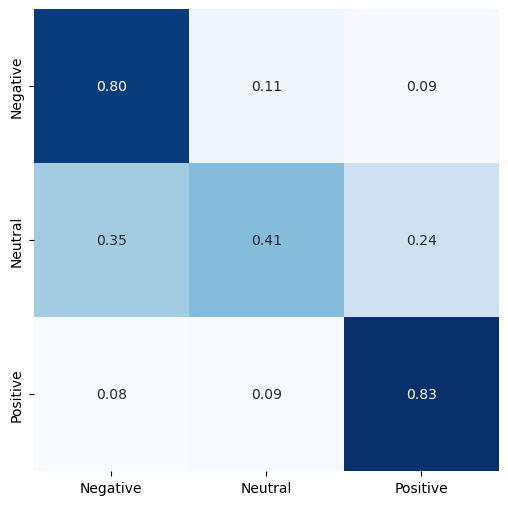

In [36]:
plot_cm(y_test, y_preds_test)

In [38]:
import pickle

In [39]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)    
with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)

In [40]:
def get_sentiment(review):
    x = preprocessor(review)
    x = tfidf_vectorizer.transform([x])
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [41]:
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [42]:
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!
